# CNN
## Ralphy Núñez Mercado 


Los MFCCs son muy utilizados en reconocimiento de voz. Utilizando la librería librosa se pueden calcular fácilmente ya que tiene una función específica para extraer estos coeficientes. Los MFCC representan una señal de audio como una versión de las características clave de la señal adaptadas a las percepción humana del sonido. Es la opción utilizada para reconocimiento de voz o clasificación de emociones en la voz.

Otra opción sería utilizar espectogramas si quisiésemos capturar una representación completa del contenido de la señal, como en casos de sonidos ambientales, clasificación de géneros musicales porque captura tanto información temporal como la de frecuencia en el audio.

TAREA

Se trata de utilizar un dataset de sonidos .wav creados por ti (sonidos de las vocales en español, por ejemplo) que extraigas los MFCCs y entrenes un modelo CNN en Keras que te permita posteriormente preprocesar nuevos audios y hacer predicciones sobre la clase más probable. Como paso previo a la predicción guarda el modelo entrenado.

Explica y documenta todo el proceso

### Imports

In [79]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report


### ⬆️ Extrae MFCCs de un archivo de audio.

In [80]:
def extraer_mfcc(file_path, n_mfcc=13, max_len=100):
    # y:  array de amplitudes
    # sr: frecuencia de muestreo
    y, sr = librosa.load(file_path, sr=None)

    # Calcular los coeficientes MFCC
    # n_mfcc: número de coeficientes a extraer (comúnmente entre 13 y 40)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Normalizar la longitud de la secuencia (número de marcos temporales)
    # Esto es necesario para que todos los audios tengan una forma uniforme como input del modelo
    if mfcc.shape[1] < max_len:
        # Si la secuencia es más corta que max_len, se rellena con ceros
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        # Si es más larga, se recorta al tamaño deseado
        mfcc = mfcc[:, :max_len]

    # Devuelve el array MFCC (forma: n_mfcc x max_len)
    return mfcc



Al principio he tenido problemas con librosa, he vuelto a hacer el entorno y ha funcionando correctamente 😓

### 🔄 Recorrer carpetas, extraer características y dividir el dataset

In [81]:

data = []
labels = []

ruta = "audios/"

# Recorremos cada carpeta
for label in os.listdir(ruta):
    dir = os.path.join(ruta, label)

    
    if os.path.isdir(dir):
        for file in os.listdir(dir):
            # comprobamos que sean archivos .wav
            if file.endswith(".wav"):
                # Extraemos los MFCCs del archivo de audio
                mfcc = extraer_mfcc(os.path.join(dir, file))
                
                # Añadimos los MFCCs al dataset
                data.append(mfcc)
                
                # Guardamos la etiqueta que será el nombre de la carpeta
                labels.append(label)

# Convertimos la lista de arrays MFCC a un array numpy de 4 dimensiones:
# (n_samples, n_mfcc, max_len, 1) el último canal es necesario para usar CNNs en Keras
data = np.array(data)
data = data[..., np.newaxis]  # Añade una dimensión de canal

# Codificamos las etiquetas de texto a números (por ejemplo: 'a' -> 0, 'e' -> 1, etc.)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# Convertimos las etiquetas codificadas
labels_categorical = to_categorical(labels_encoded)

# Dividimos el dataset en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(
    data, labels_categorical, 
    test_size=0.2, 
    random_state=42
)



### 🔄 Creación del modelo

In [82]:
modelo = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(13, 100, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')  # 5 clases (vocales)
])

modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modelo.summary()


c:\Users\ralphy.nunezmercado\AppData\Local\miniconda3\envs\audio-cnn\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 11, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 49, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 5, 49, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 47, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1472)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       188,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,005 (812.52 KB)

 Trainable params: 208,005 (812.52 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenar el modelo CNN

In [83]:
history = modelo.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_val, y_val))


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1875 - loss: 37.1632 - val_accuracy: 0.0000e+00 - val_loss: 7.5237
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.1250 - loss: 34.6666 - val_accuracy: 0.2500 - val_loss: 11.2981
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3125 - loss: 23.7070 - val_accuracy: 0.2500 - val_loss: 8.9641
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2500 - loss: 25.5722 - val_accuracy: 0.2500 - val_loss: 8.2540
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3125 - loss: 23.1714 - val_accuracy: 0.2500 - val_loss: 11.9789
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3750 - loss: 17.6598 - val_accuracy: 0.2500 - val_loss: 11.6556
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3125 - loss: 18.2264 - val_accuracy: 0.5000 - val_loss: 10.4515
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2500 - loss: 17.7273 - val_accuracy: 0.2500 - val

### ⬇️ Guardar el modelo

In [84]:
modelo.save("modelo_vocales.h5")

### Predicción sobre un nuevo audio

In [85]:
# Cargar modelo
model = load_model("modelo_vocales.h5")

# Predecir
def predecir_audio(file_path):
    mfcc = extraer_mfcc(file_path)
    mfcc = mfcc[np.newaxis, ..., np.newaxis]  # Formato (1, 13, 100, 1)
    pred = model.predict(mfcc)
    clase = le.inverse_transform([np.argmax(pred)])
    return clase[0]

# Ejemplo
print(predecir_audio("C:\\Users\\ralphy.nunezmercado\\Documents\\Directorio\\InteligenciaArtificial\\Ejercicios\\CNN\\nuevas_audios\\o\\O-nueva-grabacion.wav"))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
o


### 🔍 Visualización de precisión y perdida del modelo

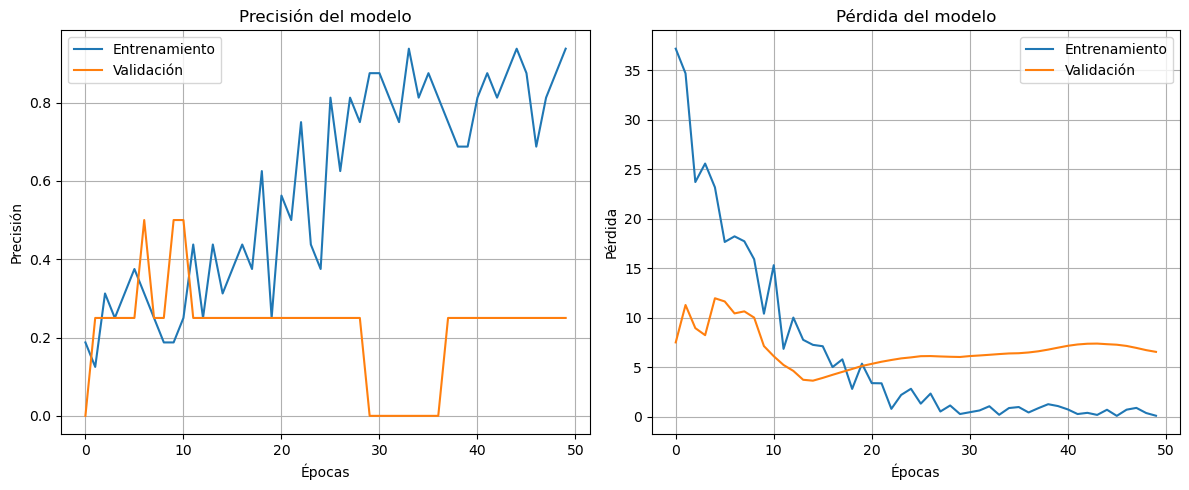

In [86]:
# Curva de precisión y pérdida
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


### 📊 Matriz de confusión y reporte de clasificación 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


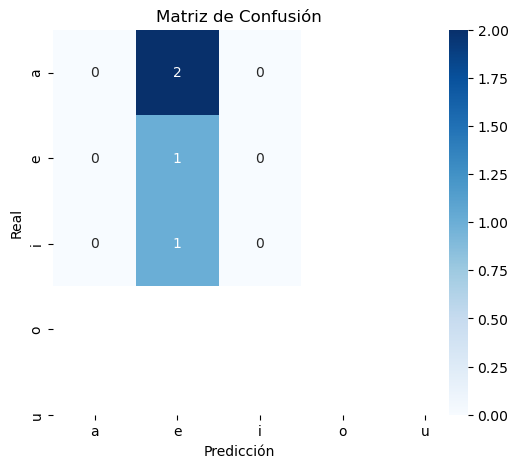

Reporte de Clasificación:

              precision    recall  f1-score   support

           a       0.00      0.00      0.00         2
           e       0.00      0.00      0.00         0
           i       0.00      0.00      0.00         0
           o       0.25      1.00      0.40         1
           u       0.00      0.00      0.00         1

    accuracy                           0.25         4
   macro avg       0.05      0.20      0.08         4
weighted avg       0.06      0.25      0.10         4



In [87]:

# Predicciones en validación
y_pred = model.predict(X_val)
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_val_labels, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


print("Reporte de Clasificación:\n")
print(classification_report(
    y_val_labels,
    y_pred_labels,
    labels=list(range(len(le.classes_))),  # asegura que estén las 5 clases
    target_names=le.classes_,              # nombres: ['a', 'e', 'i', 'o', 'u']
    zero_division=0                        # evita warnings si una clase no tiene predicciones
))


### Conclusiones: 

Debido al tamaño tan pequeño del dataset (4 audios por vocal) las predicciones no son del todo correctas, ya que suele confundir las vocales (a-i) el resto las ha predicho bien